In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math

### Data

* Join the tables for W01 and W02. 
* Select features from file and add colors. 
* Check number of members vs non members.
* Split into training, validation and testing samples.

In [2]:
df1 = pd.read_csv('../../DATA/HSC-unWISE-W01.csv')
df2 = pd.read_csv('../../DATA/HSC-unWISE-W02.csv')
df = pd.concat([df1,df2], axis = 'rows')
del df1,df2


with open('../../DATA/old_features.txt') as file:
    features = file.read().splitlines() # now i do have W1 and W1_err as features
labels = 'member'

n_mem = df[df.member == 1].shape[0]
n_no = df[df.member == 0].shape[0]
n = df.shape[0]
print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
print ('Members: {} ({:.2f}%)'.format(n_no, n_no/n*100))
del n,n_mem,n_no

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3, stratify = df[labels])
val, test = train_test_split(test, test_size = 0.3, stratify = test[labels])
print ('Training: {} members, {} non members'.format(train[train.member == 1].shape[0], train[train.member == 0].shape[0]))
print ('Validation: {} members, {} non members'.format(val[val.member == 1].shape[0], val[val.member == 0].shape[0]))
print ('Testing: {} members, {} non members'.format(test[test.member == 1].shape[0], test[test.member == 0].shape[0]))

Members: 40237 (16.58%)
Members: 202456 (83.42%)
Training: 28166 members, 141719 non members
Validation: 8450 members, 42515 non members
Testing: 3621 members, 18222 non members


### Model

In [7]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    tf.keras.callbacks.CSVLogger(filename = 'history_2.csv'),
    tf.keras.callbacks.ModelCheckpoint(filepath = 'model_2.h5', monitor = 'val_loss',  save_best_only = True),
    # tf.keras.callbacks.TensorBoard()
]

norm = tf.keras.layers.Normalization(input_shape=(len(features),))
norm.adapt(data = train[features])

In [10]:
# from imblearn.over_sampling import SMOTE
# smote_train_feat, smote_train_lab = SMOTE(sampling_strategy= 'minority').fit_resample(train[features], train[labels])
# print ('Training: {} members, {} non members'.format(smote_train_feat[smote_train_lab == 1].shape[0], smote_train_feat[smote_train_lab == 0].shape[0]))

In [4]:
from sklearn.utils.class_weight import compute_class_weight
wei =  compute_class_weight(class_weight = 'balanced', classes = np.unique(df[labels]), y = df[labels])
weights = {}
for w,l in zip(wei,np.unique(df[labels])):
    weights[l] = w

del wei
print (weights)

{0: 0.5993722092701624, 1: 3.0157939210179685}


In [8]:
model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(48, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[]
)
# tf.keras.metrics.BinaryAccuracy(name = 'accuracy'), tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.Recall(name = 'recall')

In [9]:
model.fit(
    x = train[features].values, 
    y = train[labels].values,
    verbose = 1, 
    callbacks = callbacks,
    validation_data = (val[features].values, val[labels].values), 
    epochs = 60,
    batch_size = 4096,
    class_weight = weights
)  

Epoch 1/60
42/42 [==============================] - 4s 39ms/step - loss: 0.6756 - val_loss: 0.6505
Epoch 2/60
42/42 [==============================] - 1s 26ms/step - loss: 0.6401 - val_loss: 0.6370
Epoch 3/60
42/42 [==============================] - 1s 13ms/step - loss: 0.6302 - val_loss: 0.6290
Epoch 4/60
42/42 [==============================] - 1s 14ms/step - loss: 0.6271 - val_loss: 0.6175
Epoch 5/60
42/42 [==============================] - 0s 12ms/step - loss: 0.6234 - val_loss: 0.6299
Epoch 6/60
42/42 [==============================] - 1s 23ms/step - loss: 0.6216 - val_loss: 0.6287
Epoch 7/60
42/42 [==============================] - 1s 25ms/step - loss: 0.6201 - val_loss: 0.6200
Epoch 8/60
42/42 [==============================] - 1s 25ms/step - loss: 0.6190 - val_loss: 0.6172
Epoch 9/60
42/42 [==============================] - 1s 24ms/step - loss: 0.6184 - val_loss: 0.6259
Epoch 10/60
42/42 [==============================] - 1s 23ms/step - loss: 0.6172 - val_loss: 0.6226
Epoch 11/

In [10]:
# load best model and training history
model = tf.keras.models.load_model('model_2.h5')
history = pd.read_csv('history_2.csv')

### Tests

* Training and validation loss plot
* Confusion matrix plot
* ROC curve plot
* Loss on test sample
* ROC & precision-recall AUC 
* Precision, recall, F1...


In [45]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

pred = model.predict(test[features], verbose = 0)
pred_classes = np.round(pred, decimals = 0)

test_loss = model.evaluate(test[features], test[labels], verbose=0)
fpr, tpr, thresholds_roc = roc_curve(test[labels], pred, pos_label=1)
precision, recall, thresholds_pr = precision_recall_curve(test[labels], pred, pos_label= 1)

# def model_write(string):
#     file.write(string + '\n')

# with open('report.txt', mode='x') as file:
#     model.summary(print_fn= model_write)
#     file.write('\n\n')
#     file.write('Optimizer: {} \n'.format(model.optimizer))
#     file.write('Loss function: {} \n'.format(model.loss))
#     file.write('Notes: \n')
#     file.write('-'*70 + '\n')
#     file.write('Loss on test dataset: {:.4g} \n'.format(test_loss))
#     file.write('AUC: {}\n'.format(auc(fpr, tpr)))
#     file.write('-'*70 + '\n')
#     file.write(classification_report(test[labels],pred_classes))

print('Loss on test dataset: {:.4g} \n'.format(test_loss))
print('ROC AUC: {}\n'.format(auc(fpr, tpr)))
print('Precision-recall AUC: {}\n'.format(auc(recall, precision)))
print('-'*70 + '\n')
print(classification_report(test[labels],pred_classes))

Loss on test dataset: 0.605 

ROC AUC: 0.7207473547806215

Precision-recall AUC: 0.3211315198393296

----------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.91      0.63      0.75     18222
           1       0.27      0.70      0.39      3621

    accuracy                           0.64     21843
   macro avg       0.59      0.66      0.57     21843
weighted avg       0.81      0.64      0.69     21843



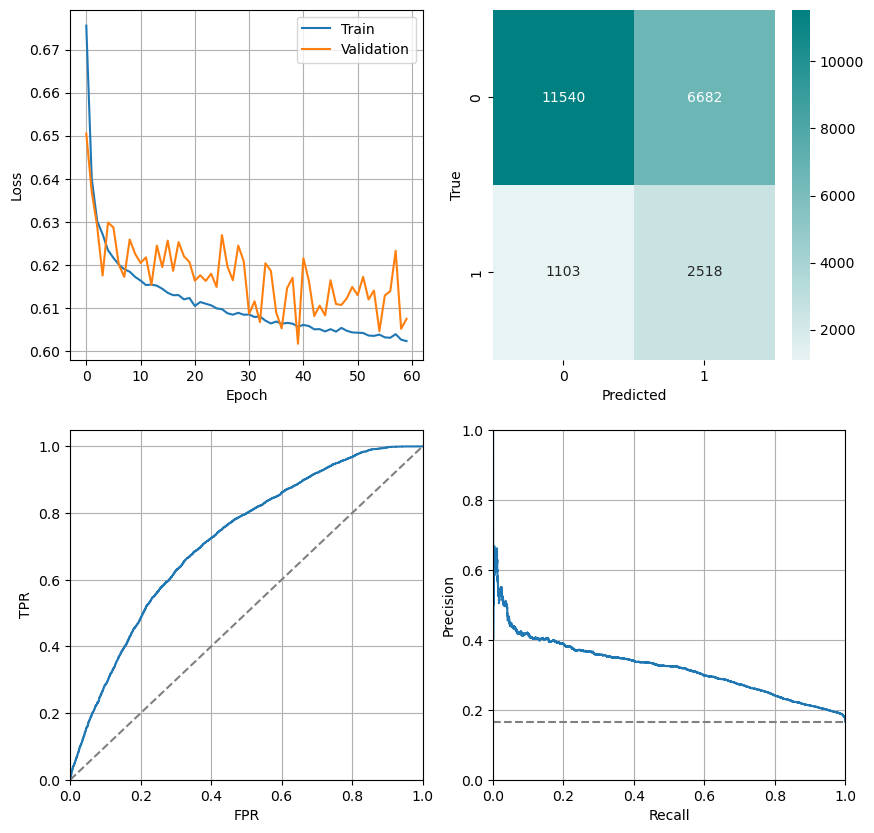

In [65]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))

# Loss during training
plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

# Confusion matrix
plt.subplot(2, 2, 2)
conf_m = confusion_matrix(test[labels], pred_classes)
df_conf_m = pd.DataFrame(conf_m, index=[0,1], columns=[0,1])
sns.heatmap(df_conf_m, cmap=sns.color_palette('light:teal', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

# ROC Curve
plt.subplot(2, 2, 3)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

# Precision-recall curve
plt.subplot(2, 2, 4)
plt.plot(recall, precision)
plt.plot([0, 1], [len (test[test.member == 1])/len(test), len (test[test.member == 1])/len(test)] , color='gray', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])

# plt.savefig('fig.png', dpi=150, bbox_inches= 'tight')
plt.show()

### Thresholds

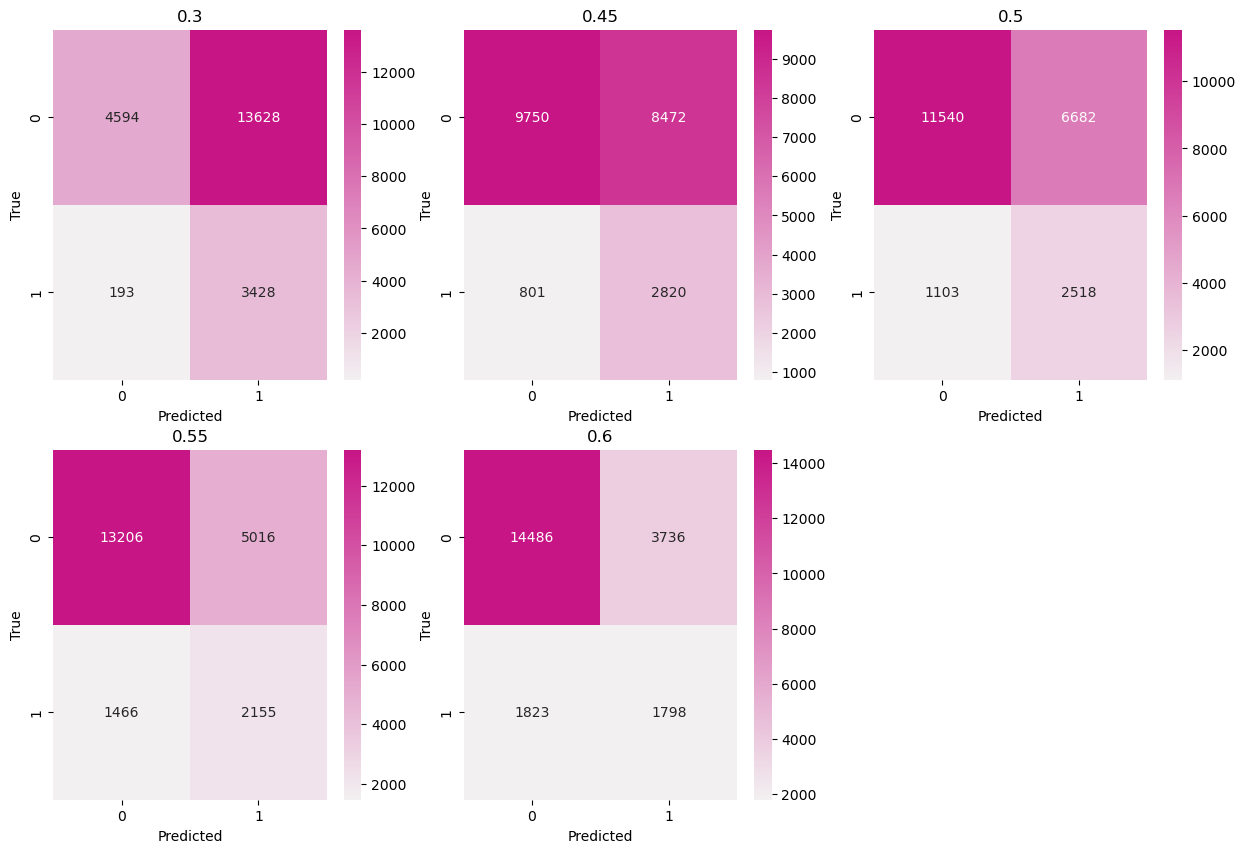

In [44]:
# get predictions with different thresholds
pred_c_thres = []
thresholds = [0.30,0.45,0.5,0.55,0.60]

for t in thresholds:
    pred_c_thres.append(
        [math.floor(p[0]) if p[0] < t else math.ceil(p[0]) for p in pred]
    )
    
# plot conf matrix for each
plt.figure(figsize=(15,10))

for i,(p,t) in enumerate(zip(pred_c_thres,thresholds)):
    plt.subplot(2, 3, i+1)
    plt.title(t)
    c = confusion_matrix(test[labels], p)
    c = pd.DataFrame(c, index=[0,1], columns=[0,1])
    sns.heatmap(c, cmap=sns.color_palette('light:mediumvioletred', as_cmap=True), annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
# plt.savefig('fig.png', dpi=150, bbox_inches= 'tight')
plt.show()

Best Threshold=0.518121, G-Mean=0.667


Text(518.4494949494949, 0.5, 'True')

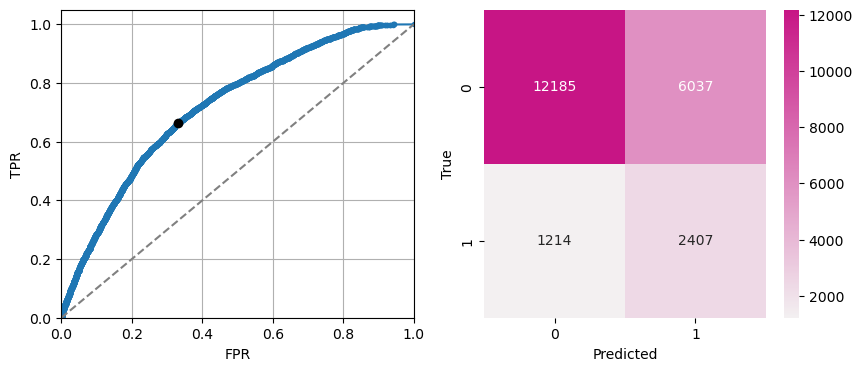

In [61]:
# With G-Mean
# calculate the g-mean for each threshold
gmeans = (tpr * (1-fpr))**(1/2)

# locate the index of the largest g-mean
max_gmeans = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_roc[max_gmeans], gmeans[max_gmeans]))

# ROC Curve
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, marker = '.')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.plot(fpr[max_gmeans], tpr[max_gmeans], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

# Conf matrix
pred_gmeans = [math.floor(p[0]) if p[0] < thresholds_roc[max_gmeans] else math.ceil(p[0]) for p in pred]
plt.subplot(1, 2, 2)
c = confusion_matrix(test[labels], pred_gmeans)
c = pd.DataFrame(c, index=[0,1], columns=[0,1])
sns.heatmap(c, cmap=sns.color_palette('light:mediumvioletred', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

Best Threshold=0.579307, F-Score=0.402


Text(518.4494949494949, 0.5, 'True')

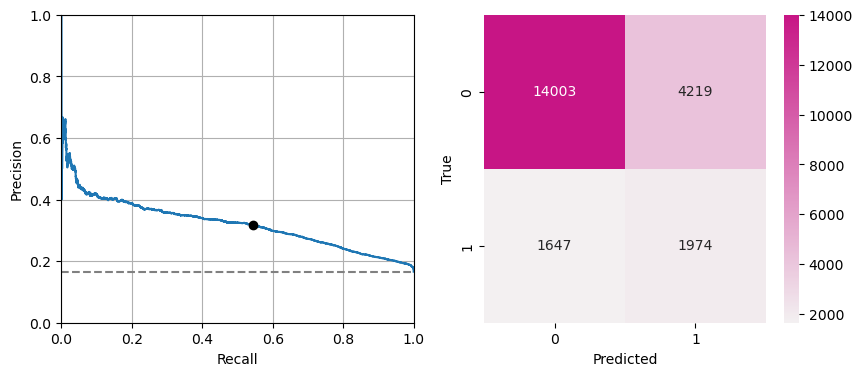

In [64]:
# with f-score
fscore = (2 * precision * recall) / (precision + recall)
max_f = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_pr[max_f], fscore[max_f]))

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(recall, precision)
plt.plot(recall[max_f], precision[max_f], marker='o', color='black', label='Best')
plt.plot([0, 1], [len (test[test.member == 1])/len(test), len (test[test.member == 1])/len(test)] , color='gray', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])

# Conf matrix
pred_f = [math.floor(p[0]) if p[0] < thresholds_pr[max_f] else math.ceil(p[0]) for p in pred]
plt.subplot(1, 2, 2)
c = confusion_matrix(test[labels], pred_f)
c = pd.DataFrame(c, index=[0,1], columns=[0,1])
sns.heatmap(c, cmap=sns.color_palette('light:mediumvioletred', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
